# K-means implementation for GPU

--------

# Introduction

**Note :**
- > Tous les calculs sont effectués sur un ordinateur de 
        - > 16Go de Ram
        - > Intel® Core™ i7-4700HQ CPU @ 2.40GHz × 8 
        - > GeForce GT 750M/PCIe/SSE2

# I. Preliminaries

- ### Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline  

from math import sqrt
import random
from sklearn.cluster import KMeans
import scipy
from scipy import spatial as sp

In [2]:
from theano.tensor import matrix
from theano import shared
from theano import function
from theano import config
from theano import tensor as T

Using gpu device 0: GeForce GT 750M (CNMeM is disabled, cuDNN not available)


- ### Simulate data

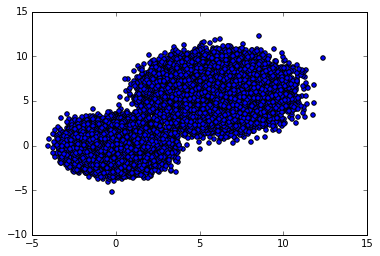

In [3]:
nb_point=100000
X = np.concatenate([np.random.multivariate_normal([0,0],[[1,0],[0,1]],nb_point),
                  np.random.multivariate_normal([6,6],[[2,0],[0,2]],nb_point)])

plt.scatter(X[:,0],X[:,1])
#change plot size

# II. Sequential approach

- ### Stanford approach

In [4]:
def kmeans(dataSet, k,MAX_ITERATIONS,epsi=0.01):

    # Initialize centroids randomly
    numFeatures = getNumFeatures(dataSet)
    centroids = getRandomCentroids(dataSet, k)
    
    # Initialize book keeping vars.
    iterations = 0
    oldCentroids = np.random.random([k,numFeatures]) #None
    
    # Run the main k-means algorithm
    while not shouldStop(oldCentroids, centroids, iterations,MAX_ITERATIONS,k,epsi):
        # Save old centroids for convergence test. Book keeping.
        oldCentroids = centroids
        iterations += 1
        
        # Assign labels to each datapoint based on centroids
        labels = getLabels(dataSet, centroids)
        
        # Assign centroids based on datapoint labels
        centroids = getCentroids(dataSet,numFeatures, labels, k)
        
    # We can get the labels too by calling getLabels(dataSet, centroids)
    clusters=getClusters(dataSet,centroids,k)
    return centroids, clusters


def shouldStop(oldCentroids, centroids, iterations,MAX_ITERATIONS,k,epsi):
    """
    Returns True or False if k-means is done. K-means terminates either
    because it has run a maximum number of iterations OR the centroids
    have reached an equilibrium.
    """
    quality=sum(np.sqrt(((oldCentroids-centroids)**2).sum(axis=1)))/k  #to change in the future
    if (iterations > MAX_ITERATIONS) | (quality<=epsi) : 
        print('Stoped at iteration : %s' %(iterations))
        if iterations > MAX_ITERATIONS:
            print('Max iterations reached, equilibrium quality of %s superior to espilon' %(quality))
        else:
            print('Equilibrium reached for epsilon = %s' %(epsi))
        return True
    else:
        return False
    
    
def getLabels(dataSet, centroids):
    """
    Returns a label for each piece of data in the dataset.
    For each element in the dataset, chose the closest centroid. 
    Make that centroid the element's label.
    This is the function which takes the most time.
    """

    mat=np.zeros(np.shape(dataSet))
    i=0
    for row in dataSet:
        dist=np.sqrt(((row-centroids)**2).sum(axis=1))
        index=np.argmin(dist,axis=0)
        mat[i]=centroids[index]
        i=i+1
    return mat


def getCentroids(dataSet,numFeatures, labels, k):
    """
    Returns k centroids, each of dimension n
    Each centroid is the geometric mean of the points that
    have that centroid's label. Important: If a centroid is empty (no points have
    that centroid's label) you should randomly re-initialize it.
    """

    #check centroids who are missing:
    sorted_data =  labels[np.lexsort(labels.T),:]
    row_mask = np.append([True],np.any(np.diff(sorted_data,axis=0),1))
    uniques=sorted_data[row_mask]
    
    #compute mean:
    centroids=np.zeros(np.shape(uniques))
    j=0
    for row in uniques:
        index=np.where(np.all(labels==row,axis=1))[0]
        #print(np.mean(dataSet[index],axis=0))
        centroids[j]=np.mean(dataSet[index],axis=0)
        j=j+1
    
    #Check number of centroids non attributed to a point
    i=k-np.shape(centroids)[0]
    
    if i==0:
        return centroids
    else:
        #concat with random missing centroids:
        print('Missing %s centroids' %(i))
        return np.concatenate([centroids,getRandomCentroids(dataSet, i)])
    
def getRandomCentroids(dataSet, k):
    """
    Returns k random centroids, each of dimension n
    For init phase, value should take a random
    position in set of range
    """
    #np.random.uniform(np.min(dataSet),np.max(dataSet),(k,numFeatures))
    #np.random.random([k,numFeatures])
    idx = np.random.randint(np.shape(dataSet)[0], size=k)
    
    return dataSet[idx,:]


def getNumFeatures(dataSet):
    """
    Returns dimensions of dataset : n-dimensions or
    n-features.
    """
    return np.shape(dataSet)[1]

def getClusters(dataSet,centroids,k):
    """
    Returns an array of scalars (1:k) of dimension nb_points.
    """
    clusters= [None]*np.shape(dataSet)[0] #np.zeros((1,np.shape(dataSet)[1]))
    for i,x in enumerate(dataSet):
        clusters[i] = min(range(k), key=lambda j: np.sqrt(((dataSet[i]-centroids[j])**2).sum(axis=0)))
    return clusters

In [5]:
%%time
t=kmeans(X,2,100,epsi=0.0)

Stoped at iteration : 3
Equilibrium reached for epsilon = 0.0
CPU times: user 5.82 s, sys: 28 ms, total: 5.84 s
Wall time: 5.83 s


CPU times: user 352 ms, sys: 12 ms, total: 364 ms
Wall time: 362 ms


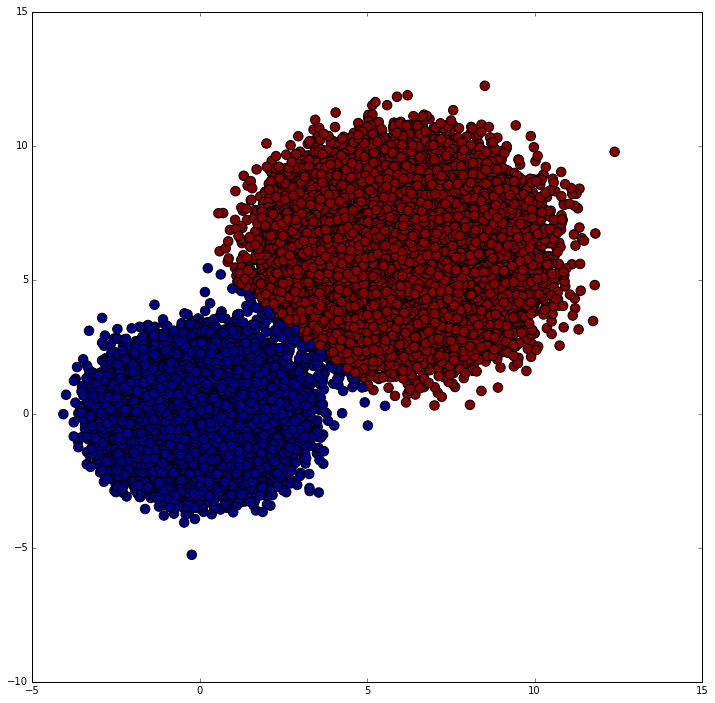

In [6]:
%%time
plt.figure(num=None, figsize=(12,12), dpi=100, facecolor='w', edgecolor='k')
plt.scatter(X[:,0],X[:,1],c=t[1],s=90)

- ## Other sequential approach

Bottle necks functions are the following, by order or priority:
- getLabels
- getCentroids
- getClusters

In [7]:
#optimize the function getLabels which takes the most time.
def getLabels(dataSet, centroids):
    """
    Returns a label for each piece of data in the dataset.
    For each element in the dataset, chose the closest centroid. 
    Make that centroid the element's label.
    This is the function which takes the most time.
    """
    #method which avoids loops with scipy cdist function
    dist_mat=sp.distance.cdist(dataSet,centroids,metric="euclidean")
    min_idx=dist_mat.argmin(axis=1) #vector of minimum index for each row
    mat=centroids[min_idx]
    return mat

In [8]:
%%time
t=kmeans(X,2,100,epsi=-1)

Stoped at iteration : 101
Max iterations reached, equilibrium quality of 0.0 superior to espilon
CPU times: user 5.01 s, sys: 8 ms, total: 5.02 s
Wall time: 4.99 s


In [9]:
%%time
t=kmeans(X,2,100,epsi=0.0)

Stoped at iteration : 4
Equilibrium reached for epsilon = 0.0
CPU times: user 2 s, sys: 12 ms, total: 2.02 s
Wall time: 1.98 s


CPU times: user 356 ms, sys: 8 ms, total: 364 ms
Wall time: 359 ms


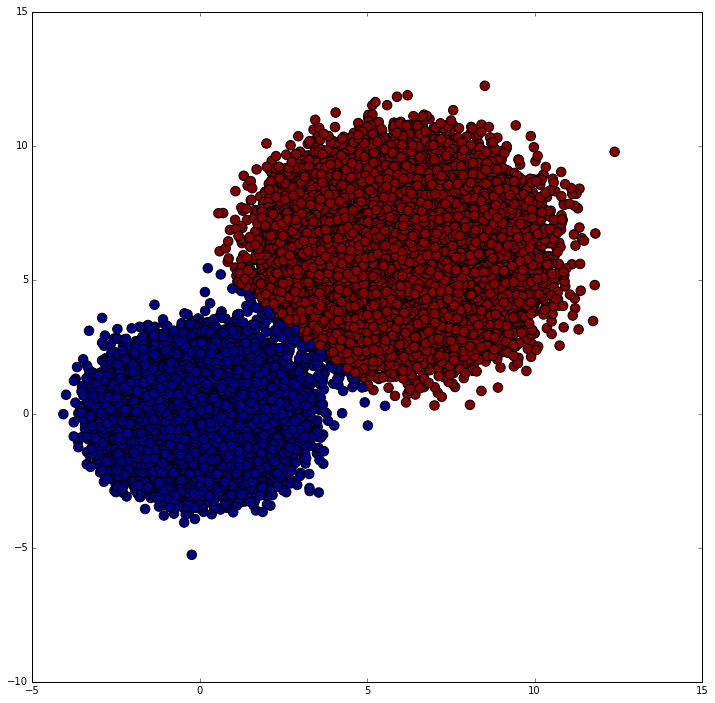

In [10]:
%%time
plt.figure(num=None, figsize=(12,12), dpi=100, facecolor='w', edgecolor='k')
plt.scatter(X[:,0],X[:,1],c=t[1],s=90)

In [11]:
# Compare with sklearn
%time KMeans(n_clusters=2, n_init=1, max_iter=100, n_jobs=1).fit(X)

CPU times: user 68 ms, sys: 228 ms, total: 296 ms
Wall time: 59.8 ms


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=2, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

- ## Test on image segmentation:

Sample size : [276480, 3]


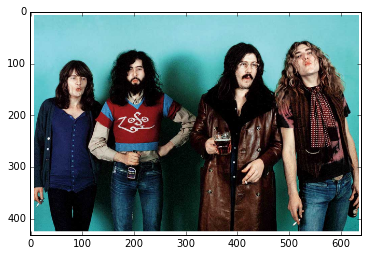

In [27]:
image = scipy.misc.imread('../data/images/orig.png')
plt.imshow(image) # showing the image
red, green, blue = image[:,:,0], image[:,:,1], image[:,:,2] # splitting up to channels
w, h = image[:,:,:3].shape[0], image[:,:,:3].shape[1] # remember original width and height
samples = np.column_stack([red.flatten(),    # creating a w*h by 3 matrix for training
                        green.flatten(),
                        blue.flatten()])
print('Sample size : %s' %(list(np.shape(samples))) )

In [28]:
%%time
k = kmeans(samples,6,100,epsi=0.0)
labels = np.array(k[1])

Stoped at iteration : 56
Equilibrium reached for epsilon = 0.0
CPU times: user 12.9 s, sys: 64 ms, total: 13 s
Wall time: 12.9 s


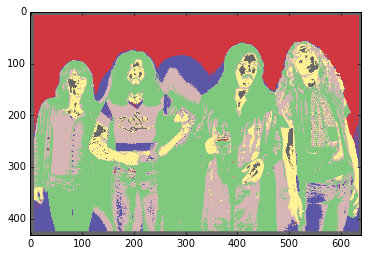

In [14]:
plt.imshow(labels.reshape((w,h)), cmap=plt.cm.Accent)

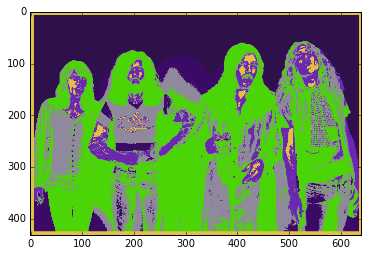

In [15]:
arr = []
for i in labels:
    arr.append(k[0][i])  

reconstruct = np.array(arr).reshape((w,h, 3))
plt.imshow(reconstruct)

Unfortunately as you can see the colors are all screwed up compared to the original image. This is because we are using the means which are vectors of floating point numbers. To be able to interpret the image correctly we need to convert these floats to integers:

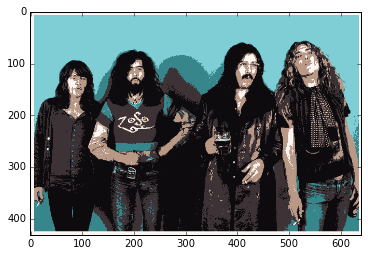

In [16]:
arr = []
for i in labels:
    arr.append(k[0][i].astype(np.uint8))
reconstruct = np.array(arr).reshape((w,h, 3))
plt.imshow(reconstruct)

In [17]:
np.shape(labels)

(276480,)

In [18]:
labels

array([5, 5, 5, ..., 5, 5, 5])

In [23]:
k[0]

array([[  13.34684268,   11.87615606,   13.07537158],
       [  61.80441481,   51.73793151,   54.83409641],
       [ 185.13416833,  152.75334472,  134.2107885 ],
       [  54.44552914,  134.56782656,  139.94969156],
       [ 128.68257788,  206.87416271,  213.12764193],
       [ 250.86407666,  246.71732712,  243.22885263]])

# III. GPU approach

In [ ]:
#optimize the function getLabels which takes the most time.
def getLabels(dataSet, centroids):
    """
    Returns a label for each piece of data in the dataset.
    For each element in the dataset, chose the closest centroid. 
    Make that centroid the element's label.
    This is the function which takes the most time.
    """
    #method which avoids loops with scipy cdist function
    dist_mat=cydist(dataSet,centroids)
    min_idx=dist_mat.argmin(axis=1) #vector of minimum index for each row
    mat=centroids[min_idx]
    return mat

def cydist(a, b):
    dims = a.shape[1]
    rows = a.shape[0]
    cols = b.shape[0]
    out = np.zeros((rows,cols)) 
    #out = theano.shared(np.zeros((rows,cols)), name="out")
    for dim in range(dims):
        out += np.subtract.outer(a[:,dim], b[:,dim])**2
    return out

In [ ]:
x_ = np.random.rand(10000, 3)
y_ = np.random.rand(5, 3)
x = T.TensorType("float64", [False, True, False])()
w = T.TensorType("float64", [True, False, False])()

z = T.sum((x-w)**2, axis=2)
fn = function([x, w], z)
print fn([[[0,1,2,4]], [[1,2,3,4]], [[1,2,3,4]]], [[[1,1,1,4], [2,2,2,4]]])

In [ ]:
x

In [ ]:
b = shared(x_)
b=b.dimshuffle([0,'x',1])

In [ ]:
b

In [ ]:

x_ = np.random.rand(10000, 3)
y_ = np.random.rand(5, 3)
x = T.TensorType("float64", [False, True, False])()
w = T.TensorType("float64", [True, False, False])()
a = shared(x_,).dimshuffle([1, 'x', 0])
b = shared(y_).dimshuffle([0, 'x', 1])
z = T.sum((x-w)**2, axis=2)
fn = function([x, w], z)
print fn(a,b)

In [ ]:
def cydist_(a, b):
    x = shared(a, name="x")
    w = shared(b, name="w")
    func = T.sum((x-w)**2, axis=1)
    fn = function([x, w], func)
    return fn([x, w], func)

In [ ]:
x_ = np.random.rand(10000, 3)
y_ = np.random.rand(5, 3)
%time t=cydist_(x_,y_)

In [ ]:
%%time
k = kmeans(X,2,100,epsi=0.0)
labels = np.array(k[1])

In [ ]:
%%time
plt.figure(num=None, figsize=(12,12), dpi=100, facecolor='w', edgecolor='k')
plt.scatter(X[:,0],X[:,1],c=t[1],s=90)

In [ ]:
%%time
k = kmeans(samples,6,100,epsi=0.0)
labels = np.array(k[1])

In [ ]:
arr = []
for i in labels:
    arr.append(k[0][i].astype(np.uint8))
reconstruct = np.array(arr).reshape((w,h, 3))
plt.imshow(reconstruct)

In [ ]:
def cydist(a, b):
    dims = a.shape[1]
    rows = a.shape[0]
    cols = b.shape[0]
    out = np.zeros((rows,cols))
    print(np.shape(out))
    for dim in range(dims):
        out += np.subtract.outer(a[:,dim], b[:,dim])**2
    return out

In [ ]:
x = np.random.rand(10000, 3)
y = np.random.rand(5, 3)
%time t=cydist(x,y)

In [ ]:
from theano.tensor import matrix
from theano import shared
from theano import function
from theano import config
import numpy as np

x = np.random.rand(10000, 3).astype(config.floatX)
X_i = shared(x[None, :, :], broadcastable=(True, False, False))
X_j = shared(x[:, None, :], broadcastable=(False, True, False))
print X_i
print X_j

dX = (X_i - X_j)**2
Dsq = dX.sum(axis=2)
D = Dsq**0.5
import time
start = time.time()
D.eval()
print time.time() - start

In [ ]:
z=D.eval()
np.shape(z)

In [ ]:
z[0,2]

In [ ]:
import scipy
scipy.spatial.distance.euclidean(x[0,:],x[2,0])

In [ ]:
scipy.spatial.distance.pdist(x, metric='euclidean')

In [ ]:
import theano
import theano.tensor as T
X = T.fmatrix('X')
Y = T.fmatrix('Y')
P = T.scalar('P')
translation_vectors = X.reshape((X.shape[0], 1, -1)) - Y.reshape((1, Y.shape[0], -1))
minkowski_distances = (abs(translation_vectors) ** P).sum(2) ** (1. / P)
f_minkowski = theano.function([X, Y, P], minkowski_distances)

In [ ]:
import numpy as np
from scipy.spatial.distance import pdist

rng = np.random.RandomState(42)
d = 20 # dimension
nX = 10
nY = 30
x = rng.randn(nX, d).astype(np.float32)
y = rng.randn(nY, d).astype(np.float32)

ps = [1., 3., 2.]

for p in ps:
    d_theano = f_minkowski(x, x, p)[np.triu_indices(nX, 1)]
    d_scipy = pdist(x, p=p, metric='minkowski')
    print "Testing p=%1.2f, discrepancy %1.3e" % (p, np.sqrt(((d_theano - d_scipy) ** 2).sum()))

In [ ]:
squared_euclidean_distances = (X ** 2).sum(1).reshape((X.shape[0], 1)) + (Y ** 2).sum(1).reshape((1, Y.shape[0])) - 2 * X.dot(Y.T)
f_euclidean = theano.function([X, Y], T.sqrt(squared_euclidean_distances))